In [69]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report
import xgboost as xgb
from sklearn.metrics import accuracy_score, roc_auc_score
import seaborn as sns

In [12]:
train = pd.read_csv('train.csv')
train = train.assign(**train.select_dtypes('string').astype('category'))

In [13]:
f = ['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length']
t = 'loan_status'

take aways:
- imbalanced target set (less defaulted loans)
- overproportionally don't fit low loan grades / high interest 

# xgboost

Accuracy train: 0.9566459203683179
AUC-ROC train: 0.9714668948065172
Accuracy: 0.9535339756159945
AUC-ROC: 0.9564345311502473
id                            0.006814
person_age                    0.007540
person_income                 0.034752
person_home_ownership         0.034108
person_emp_length             0.009141
loan_intent                   0.028479
loan_grade                    0.204106
loan_amnt                     0.006846
loan_int_rate                 0.155920
loan_percent_income           0.057133
cb_person_default_on_file     0.447664
cb_person_cred_hist_length    0.007495
dtype: float32


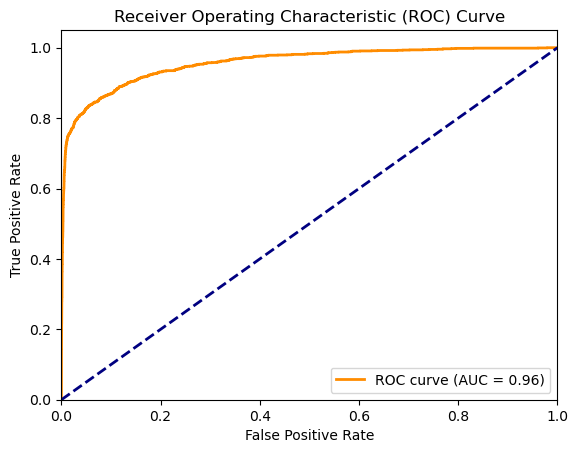

AUC-ROC: 0.9564


In [112]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Assuming you have a DataFrame 'df' with features and a target column 'target'
X = train.drop(t, axis=1)
y = train[t]

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        #('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
        ('cat', OrdinalEncoder(), categorical_columns) #slightly better
    ])

# Create the pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=4))
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

from sklearn.utils.class_weight import compute_sample_weight

# Compute sample weights
sample_weights = compute_sample_weight("balanced", y_train)

# Fit the pipeline
xgb_pipeline.fit(X_train, y_train, classifier__sample_weight=sample_weights)

# Make predictions
y_pred = xgb_pipeline.predict(X_train)
y_pred_proba = xgb_pipeline.predict_proba(X_train)[:, 1]
print("Accuracy train:", accuracy_score(y_train, y_pred))
print("AUC-ROC train:", roc_auc_score(y_train, y_pred_proba))

y_pred = xgb_pipeline.predict(X_test)
y_pred_proba = xgb_pipeline.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred_proba))

# If you want to access the XGBoost model directly (e.g., for feature importance)
xgb_model = xgb_pipeline.named_steps['classifier']

# Feature importance (be careful, as this will include one-hot encoded features)
feature_importance = xgb_model.feature_importances_
imp = pd.Series(data=feature_importance,index=f)
print(imp.T)
printauc(y_test,y_pred_proba)

## investigate false positives

In [119]:
testDf = X_test
testDf['predProb'] = y_pred_proba
testDf['pred'] = y_pred
testDf['gt'] = y_test
testDf['agree'] = testDf['gt'] == testDf['pred']

In [120]:
testDf.columns

Index(['id', 'person_age', 'person_income', 'person_home_ownership',
       'person_emp_length', 'loan_intent', 'loan_grade', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_default_on_file',
       'cb_person_cred_hist_length', 'predProb', 'pred', 'gt', 'agree'],
      dtype='object')

Adding the weight of having an imbalanced distribution causes to
- incorrectly classify good loand as bad for high percentages

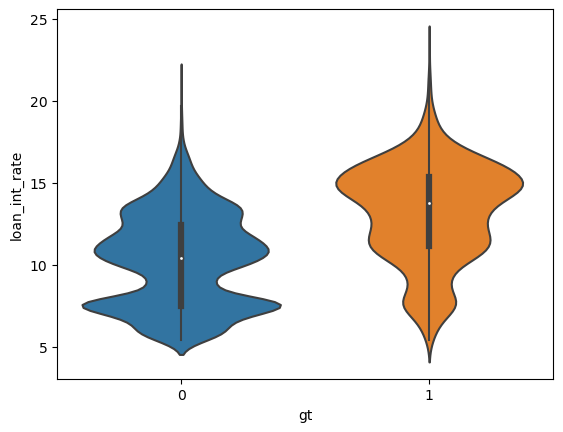

In [137]:
ax1 = sns.violinplot(testDf, x='gt',y='loan_int_rate',alpha=0.1)

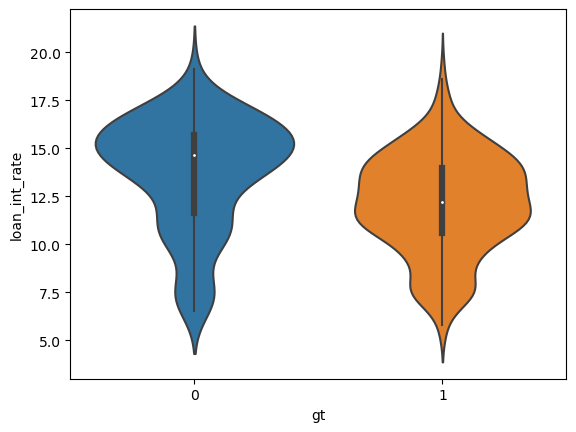

In [135]:
# we tend to mess up high interest rates
ax1 = sns.violinplot(testDf.loc[testDf.agree==False], x='gt',y='loan_int_rate',alpha=0.1)
#ax2 = sns.violinplot(testDf.loc[testDf.agree==True], x='gt',y='loan_int_rate')#,ax=ax1) #
#plt.setp(ax1.collections, alpha=.5)
# baad predictions -> over proportionally classifying high interest rates as bad loans

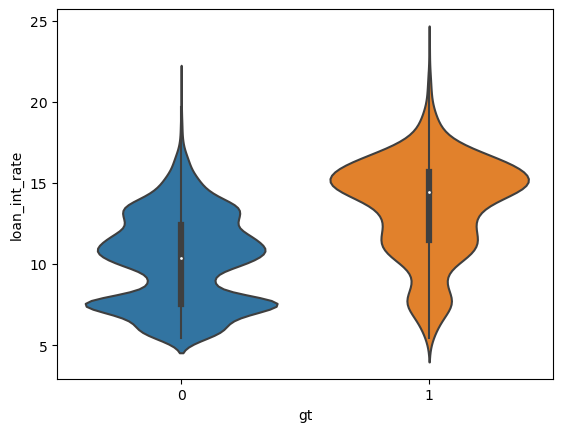

In [136]:
# weird thing, for the correct predictions the majority has low interest rates
# weird the distribution for correctly predicted & bad loan is the same as
#                        for incorrect predicted & good loan

ax2 = sns.violinplot(testDf.loc[testDf.agree==True], x='gt',y='loan_int_rate')

In [81]:
# we slighly miss more rent people to predict
pd.crosstab(index=testDf['agree'],columns=testDf['person_home_ownership'],normalize='index').style.background_gradient(cmap='RdBu')

person_home_ownership,MORTGAGE,OTHER,OWN,RENT
agree,,,,
False,0.350459,0.001835,0.014679,0.633028
True,0.427039,0.001699,0.054989,0.516273


In [83]:
# home improvement, medical and personal do not align
pd.crosstab(index=testDf['agree'],columns=testDf['loan_intent'],normalize='index').style.background_gradient(cmap='RdBu')

loan_intent,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE
agree,,,,,,
False,0.141284,0.179817,0.159633,0.212844,0.209174,0.097248
True,0.153433,0.212715,0.101484,0.184460,0.167918,0.179989


In [113]:
# same picture as intrest rate, the bad loand we tend to predict incorrectly
pd.crosstab(index=testDf['agree'],columns=testDf['loan_grade'],normalize='index').style.background_gradient(cmap='RdBu')

loan_grade,A,B,C,D,E,F,G
agree,,,,,,,
False,0.142112,0.318123,0.322034,0.182529,0.028683,0.005215,0.001304
True,0.374567,0.352399,0.176063,0.079821,0.014596,0.002007,0.000547


In [114]:
# if there is a defaulted person close by we miss the predicion more often
pd.crosstab(index=testDf['agree'],columns=testDf['cb_person_default_on_file'],normalize='index').style.background_gradient(cmap='RdBu')

cb_person_default_on_file,N,Y
agree,,
False,0.719687,0.280313
True,0.865809,0.134191


In [118]:
# we tend to predict 1 a lot less -> imbalanced dataset
pd.crosstab(index=testDf['agree'],columns=testDf['gt'],normalize='index').style.background_gradient(cmap='RdBu')

gt,0,1
agree,,
False,0.220183,0.779817
True,0.891184,0.108816


In [111]:
testDf.groupby('agree')['gt'].value_counts()

agree  gt
False  0      471
       1      296
True   0     9616
       1     1346
Name: count, dtype: int64

In [101]:
testDf['gt'].value_counts(),train['loan_status'].value_counts()

(gt
 0    10087
 1     1642
 Name: count, dtype: int64,
 loan_status
 0    50295
 1     8350
 Name: count, dtype: int64)

# auc curve

In [29]:
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def printauc(y_test,y_pred):

    # Calculate ROC curve points
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print(f"AUC-ROC: {roc_auc:.4f}")

# ensemble

In [22]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.base import BaseEstimator, RegressorMixin

# Custom ensemble model
class EnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, models, final_estimator):
        self.models = models
        self.final_estimator = final_estimator

    def fit(self, X, y):
        # Fit base models
        self.fitted_models_ = [model.fit(X, y) for model in self.models]
        
        # Generate predictions from base models
        X_meta = np.column_stack([model.predict(X) for model in self.fitted_models_])
        
        # Fit final estimator
        self.final_estimator.fit(X_meta, y)
        return self

    def predict(self, X):
        # Generate predictions from base models
        X_meta = np.column_stack([model.predict(X) for model in self.fitted_models_])
        
        # Final prediction
        return self.final_estimator.predict(X_meta)

# Assuming you have a DataFrame 'df' with features and a target column 'target'
X = train.drop(t, axis=1)
y = train[t]

# Identify categorical and numerical columns
categorical_columns = X.select_dtypes(include=['object', 'category']).columns
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Create base models
xgb_model = XGBRegressor(use_label_encoder=False, eval_metric='rmse')
rf_model = RandomForestRegressor(random_state=42)
lr_model = LinearRegression()

# Create the ensemble model
ensemble_model = EnsembleRegressor(
    models=[
        Pipeline([('preprocessor', preprocessor), ('regressor', xgb_model)]),
        Pipeline([('preprocessor', preprocessor), ('regressor', rf_model)]),
        Pipeline([('preprocessor', preprocessor), ('regressor', lr_model)])
    ],
    final_estimator=LinearRegression()
)

# Create the final pipeline
final_pipeline = Pipeline([
    ('ensemble', ensemble_model)
])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the pipeline
final_pipeline.fit(X_train, y_train)

# Make predictions
y_pred = final_pipeline.predict(X_test)
y_predClass = y_pred > 0.5

# Evaluate the model (you can add your preferred evaluation metrics here)
from sklearn.metrics import accuracy_score, roc_auc_score
print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", roc_auc_score(y_test, y_pred))

AttributeError: 'EnsembleRegressor' object has no attribute 'predict_proba'

In [27]:
y_predClass = y_pred > 0.5

# Evaluate the model (you can add your preferred evaluation metrics here)
from sklearn.metrics import accuracy_score, roc_auc_score
print("Accuracy:", accuracy_score(y_test, y_predClass))
print("AUC-ROC:", roc_auc_score(y_test, y_predClass))

Accuracy: 0.947992156194049
AUC-ROC: 0.8535113574025346


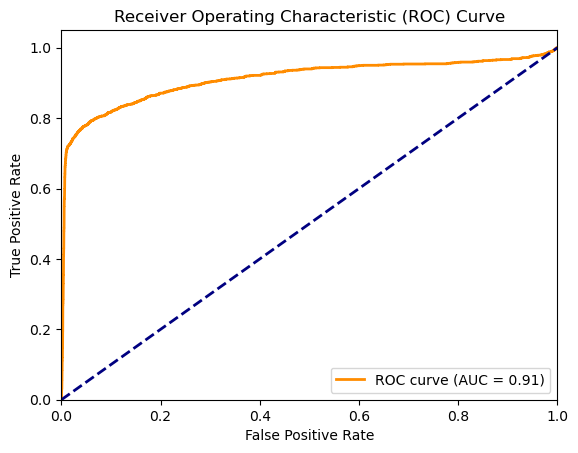

AUC-ROC: 0.9111


In [30]:
printauc(y_test,y_pred)